# Análise de tweets referentes às delações da JBS

In [16]:
import re
import csv
import numpy as np
import pandas as pd
import datetime

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Definindo a limpeza feita nos tweets

Remover números;

Remover caracteres que não são letras;

Remover espaços extras;

In [17]:
RE_NUMBERS = re.compile(r'[0-9]+')
RE_NOT_LETTERS = re.compile(r'[^a-zA-Z]+')
RE_SPACES = re.compile(r'[^\S\f\t\n\r]+')

def clean_text(text):
    text = RE_NUMBERS.sub(' NUM ', text)
    text = RE_NOT_LETTERS.sub(' ', text)
    text = RE_SPACES.sub(' ', text)
    return text.lower()

## Lendo arquivo csv contendo os tweets

As colunas estão separadas por ';'

In [18]:
rows = []
with open('tweets/tweets_some_labeled.csv', newline='', encoding='utf-8') as csvfile:
    for row in csvfile.readlines():
        rows += [row.split(';')]

## Salvando tweets estruturadamente

A primeira coluna determina a data do tweet, no formato 'yyyy/mm/dd';

A segunda coluna determina o conteúdo do tweet, este já limpo;

A terceira coluna contém um rótulo (0 ou 1) para o tweet, caso tal tweet participe do conjunto de treinamento/teste. O tweet pode não conter esse valor;

In [19]:
tweets = [[row[0], clean_text(row[1]), row[2].replace('\r\n','')] for row in rows]
print('Tweets\' set size: ' + str(len(tweets)))

Tweets' set size: 243002


## Pegando tweets classificados

Estes serão usados para gerar o classificador de tweets.

É salvo o conteúdo do tweet, bem como a sua classificação.

In [20]:
# Tweet takes part on training set if it is labeled (third column)
classified_tweets = [tweet for tweet in tweets if tweet[2] != '']
classified_tweets_text = [tweet[1] for tweet in classified_tweets]
classified_tweets_target = [int(tweet[2]) for tweet in classified_tweets]
print('Training set size: ' + str(len(classified_tweets)))

Training set size: 500


## É feita a vetorização dos tweets, pelo método "Bag of words"

Considerando um conjunto de N tweets classificados, cada tweet terá uma representação vetorial, onde o número de dimensões K do vetor é definido pelo tamanho do vocabulário (número de palavras existentes) do conjunto de tweets;

Para cada tweet, cada posição Ki do seu vetor conterá o número de repetições da palavra correspondente à posição Ki.

In [21]:
# Vectorizing tweets
tweet_vectorizer = CountVectorizer()
tweet_vectorizer.fit(classified_tweets_text)

vectorized_classified_tweets = tweet_vectorizer.transform(classified_tweets_text)
labels_classified_tweets = np.array(classified_tweets_target)

## É usado Stratified K-fold para a geração do classificador de tweets

Dado o conjunto de tweets classificados, este é dividido randomicamente em dois subconjuntos complementares: Treinamento e Teste.

Com isso, gera-se um classificador Naive-Bayes baseado no conjunto de tweets de treinamento. Tal classificador tem a sua acurácia avaliada baseada no conjunto de teste.

Este processo é repetido um número X de vezes. Logo, são gerados X classificadores diferentes.

O classificador resultante será o que possui a maior acurácia.

In [22]:
# Stratified K-fold
# Random training sets in order to choose the best classifier
number_of_folds = 100
stratified_kfold = StratifiedKFold(n_splits=number_of_folds, shuffle=True)

best_classifier = None
best_classifier_score = 0

for i, (train_indices, test_indices) in enumerate(stratified_kfold.split(vectorized_classified_tweets, labels_classified_tweets)):
    current_nb_classifier = MultinomialNB()

    train_instances = vectorized_classified_tweets[train_indices]
    train_classes = labels_classified_tweets[train_indices]
    test_instances = vectorized_classified_tweets[test_indices]
    test_classes = labels_classified_tweets[test_indices]

    current_nb_classifier.fit(train_instances, train_classes)
    score = current_nb_classifier.score(test_instances, test_classes)
    
    if score > best_classifier_score:
        best_classifier = current_nb_classifier
        best_classifier_score = score
        
print(best_classifier_score)

1.0


## Usando o classificador gerado para classificar todos os tweets da base

In [23]:
# Classify all tweets dataset
tweets_text = [tweet[1] for tweet in tweets]
vectorized_tweets = tweet_vectorizer.transform(tweets_text)
labels_tweets = best_classifier.predict(vectorized_tweets)

## Estruturar resultados para visualização

Uma lista é gerada contendo informações a respeito da quantidade de tweets de cada dia, bem como suas características;

Cada elemento da lista representa um data (dia) de tweets, onde contém-se informações a respeito da quantidade total de tweets, a quantidade de tweets referentes aos eventos de delações da JBS e quantidade de tweets complementares.

In [24]:
tweets_dates_labels = [(tweet[0], label) for tweet, label in zip(tweets, labels_tweets)]

tweets_dates_count = []
current_date = ''
for i in range(len(tweets_dates_labels)):
    date, label = tweets_dates_labels[i]
    if (date == current_date):
        head = len(tweets_dates_count) - 1
        tweets_dates_count[head] = (\
            tweets_dates_count[head][0],\
            tweets_dates_count[head][1] + 1,\
            tweets_dates_count[head][2] + label,\
            tweets_dates_count[head][3] + (not label),\
        )
    else:
        tweets_dates_count += [(date, 1, label, not label)]
    current_date = date

## Visualização das três informações descritas anteriormente

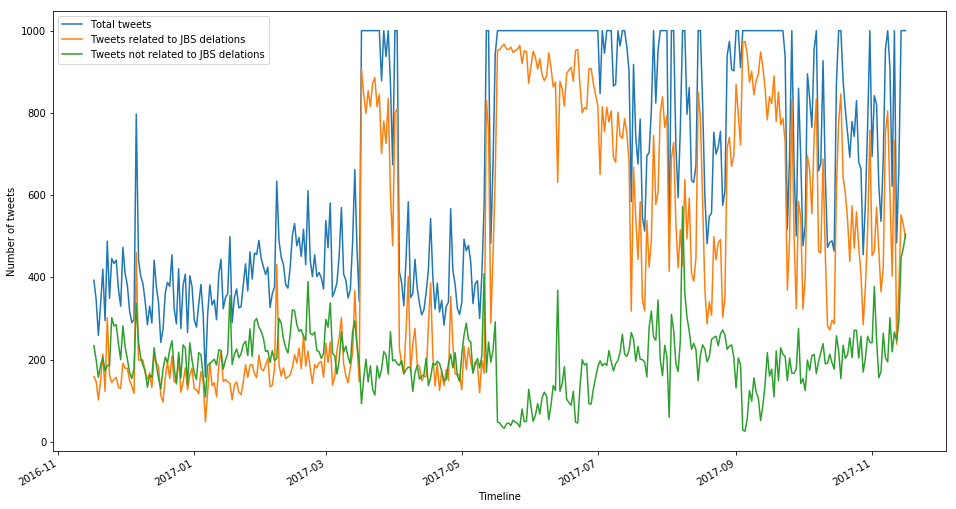

In [25]:
times = pd.date_range(tweets_dates_count[0][0], periods=365)

fig, ax = plt.subplots(figsize=(16, 9))
fig.autofmt_xdate()

plt.xlabel("Timeline")
plt.ylabel("Number of tweets")
plt.plot(times, [tweet[1] for tweet in tweets_dates_count], label='Total tweets')
plt.plot(times, [tweet[2] for tweet in tweets_dates_count], label='Tweets related to JBS delations')
plt.plot(times, [tweet[3] for tweet in tweets_dates_count], label='Tweets not related to JBS delations')

plt.legend()
plt.show()

In [37]:
tweets_related_per_day = [(tweet[0], tweet[2]) for tweet in tweets_dates_count]

with open('tweets/tweets_related_per_day.csv', 'w', newline='') as tweets_day_csv:
    spamwriter = csv.writer(tweets_day_csv, delimiter=';')
    for tweet in tweets_related_per_day:
        spamwriter.writerow(list(tweet))

In [38]:
def get_week_day(date):
    return datetime.datetime.strptime(date, '%d/%m/%Y').strftime('%A')

tweets_related_per_week = []
current_week = [tweets_related_per_day[0][0], 0]
for tweet in tweets_related_per_day:
    current_weekday = get_week_day(tweet[0])
    if current_weekday != 'Sunday':
        current_week[1] += tweet[1]
    else:
        tweets_related_per_week.append(tuple(current_week))
        current_weekday = get_week_day(tweet[0])
        current_week = list(tweet)
tweets_related_per_week.append(tuple(current_week))

with open('tweets/tweets_related_per_week.csv', 'w', newline='') as tweets_week_csv:
    spamwriter = csv.writer(tweets_week_csv, delimiter=';')
    for tweet in tweets_related_per_week:
        spamwriter.writerow(list(tweet))